קצר הסבר  לכתוב

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans 

# loading csv file
csv_path = "mxmh_survey_results.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    raise SystemExit(f"CSV not found at {csv_path}")
except Exception as e:
    raise SystemExit(f"Failed to read CSV: {e}")

נתונים יבשים מקדימים על הדאטא

In [2]:
df.info(verbose=False)  # Get a summary of the DataFrame structure without listing all columns
print("\n")

#classifyng type of values
dtypes = df.dtypes.unique()  #showing which columns belong to each data type
print("conclusion of data type:\n")
for dtype in dtypes:
    cols = df.select_dtypes(include=[dtype]).columns.tolist()  #Select all columns of the current data type and convert their names to a list
    print(f"Data type: {dtype} ({len(cols)} columns)")
    print("Columns:", ", ".join(cols), "\n")
print("\n")


#showing basic data such as sample size, mean, std, min, max, first and third quartile, median.
basic_statistic_data = df.describe()
print (basic_statistic_data)
print("\n")

#finding the sum of missing values in every column
missing_values = df.isnull().sum()
print("we can find missing values in the next categories:\n")
for col in missing_values.index:
    if missing_values[col] > 0:
        print(f"{col}: {missing_values[col]} missing values")
print("\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Columns: 33 entries, Timestamp to Permissions
dtypes: float64(7), object(26)
memory usage: 189.9+ KB


conclusion of data type:

Data type: object (26 columns)
Columns: Timestamp, Primary streaming service, While working, Instrumentalist, Composer, Fav genre, Exploratory, Foreign languages, Frequency [Classical], Frequency [Country], Frequency [EDM], Frequency [Folk], Frequency [Gospel], Frequency [Hip hop], Frequency [Jazz], Frequency [K pop], Frequency [Latin], Frequency [Lofi], Frequency [Metal], Frequency [Pop], Frequency [R&B], Frequency [Rap], Frequency [Rock], Frequency [Video game music], Music effects, Permissions 

Data type: float64 (7 columns)
Columns: Age, Hours per day, BPM, Anxiety, Depression, Insomnia, OCD 



              Age  Hours per day           BPM     Anxiety  Depression  \
count  735.000000     736.000000  6.290000e+02  736.000000  736.000000   
mean    25.206803       3.572758  1.589948e

הכנה לניתוח, יצירת מדד משוקלל לחרדה ודיכאון והמרת ערכים קטגוריאליים למספרים, בדיקה של קלאסטרינג למשתנים רלוונטיים וסיווג לקבוצות לפי זה


לא הצלחתי כאן ליצור את הקלאסטרינג, לא הבנתי למה, צריך לבדוק

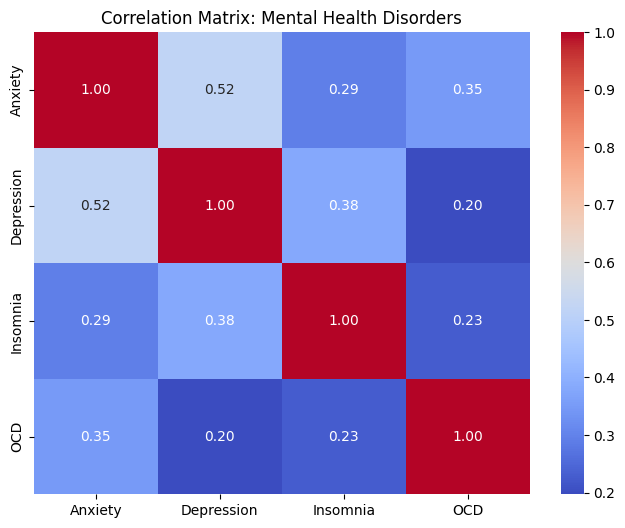

Error: No complete data left after dropping missing values.


In [12]:

# Plot 1: Heatmap of Mental Health disorders
health_cols = ["Anxiety", "Depression", "Insomnia", "OCD"]
plt.figure(figsize=(8, 6))
sns.heatmap(df[health_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Mental Health Disorders")
plt.show() # Code to display the graph

# Create Weighted Distress Index (Anxiety + Depression) because of their high correlation seen in the heatmap
df['Distress_Index'] = df[['Anxiety', 'Depression']].mean(axis=1)

# Numerical Encoding of genre frequencies
# Never=0, Rarely=1, Sometimes=2, Very frequently=3
freq_mapping = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Very frequently': 3}
genre_cols = [col for col in df.columns if col.startswith('Frequency [')]
for col in genre_cols:
    df[col] = df[col].apply(lambda x: freq_mapping.get(x.strip()) if isinstance(x, str) else x)

# Genre Clustering (Grouping genres based on listener patterns)
# We drop rows with missing values first, then convert to float to avoid errors
genre_data = df[genre_cols].dropna().astype(float).T
# Safety check: proceed only if data is not empty
if not genre_data.empty:
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    genre_clusters = kmeans.fit_predict(genre_data)


    # Map genres to their respective cluster IDs
    clusters_dict = {i: [] for i in range(3)}
    for genre, cluster_id in zip(genre_cols, genre_clusters):
        clusters_dict[cluster_id].append(genre)

    # Create aggregate variables for each cluster to use in regression
    for cid, genres in clusters_dict.items():
        df[f'Genre_Cluster_{cid}'] = df[genres].mean(axis=1)


    # Printing identified genre clusters
    print("\n--- Identified Genre Clusters ---")
    for cid, genres in clusters_dict.items():
        clean_names = [g.replace('Frequency [', '').replace(']', '') for g in genres]
        print(f"Cluster {cid}: {', '.join(clean_names)}")
else:
    print("Error: No complete data left after dropping missing values.")
    

גרפים ותכלס


--- Regression Analysis Results ---
                            OLS Regression Results                            
Dep. Variable:         Distress_Index   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     11.66
Date:                Thu, 08 Jan 2026   Prob (F-statistic):           7.37e-11
Time:                        16:06:25   Log-Likelihood:                -1699.3
No. Observations:                 735   AIC:                             3411.
Df Residuals:                     729   BIC:                             3438.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const

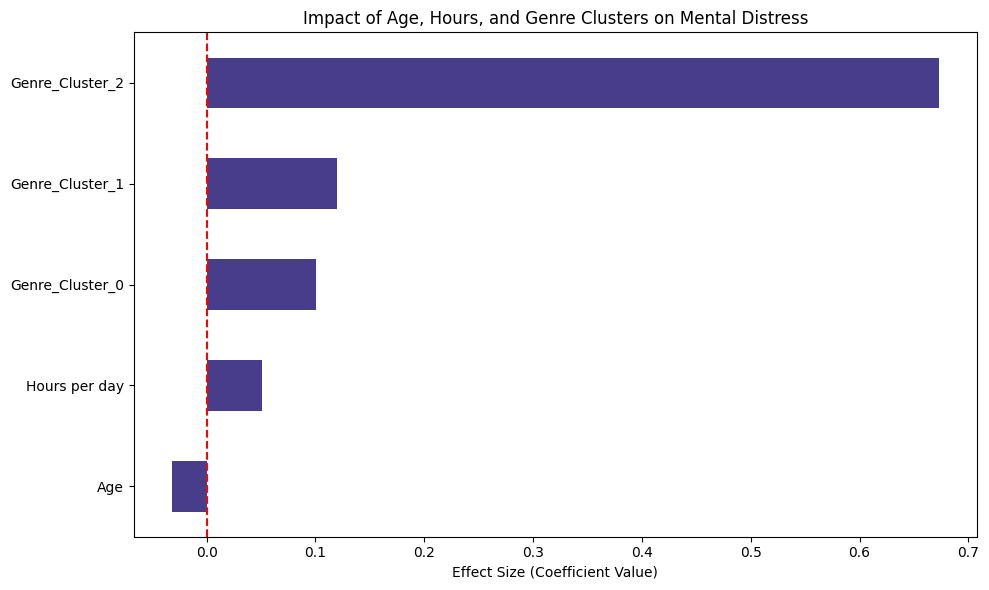


--- Identified Genre Clusters ---
Cluster 0: Hip hop, R&B, Rap
Cluster 1: Classical, Country, EDM, Folk, Gospel, Jazz, K pop, Latin, Lofi, Video game music
Cluster 2: Metal, Pop, Rock


In [ ]:
# Regression Model calculation (before plotting)
predictors = ['Age', 'Hours per day', 'Genre_Cluster_0', 'Genre_Cluster_1', 'Genre_Cluster_2']
analysis_df = df[['Distress_Index'] + predictors].dropna()
X = analysis_df[predictors]
X = sm.add_constant(X)
y = analysis_df['Distress_Index']
model = sm.OLS(y, X).fit()
print("\n--- Regression Analysis Results ---")
print(model.summary())

# Plot 2: Regression Coefficients
plt.figure(figsize=(10, 6))
model.params[1:].plot(kind='barh', color='darkslateblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Impact of Age, Hours, and Genre Clusters on Mental Distress")
plt.xlabel("Effect Size (Coefficient Value)")
plt.tight_layout()
plt.show() # Code to display the graph


